### Imports

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
"""
Inspired by Stata's binscatter, described fully by Michael Stepner at
https://michaelstepner.com/binscatter/.
"""
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import linear_model
from scipy import sparse as sps


def get_binscatter_objects(y, x, controls, n_bins, recenter_x, recenter_y, bins):
    """
    Returns mean x and mean y within each bin, and coefficients if residualizing.
    Parameters are essentially the same as in binscatter.
    """
    # Check if data is sorted

    if controls is None:
        if np.any(np.diff(x) < 0):
            argsort = np.argsort(x)
            x = x[argsort]
            y = y[argsort]
        x_data = x
        y_data = y
    else:
        # Residualize
        if controls.ndim == 1:
            controls = controls[:, None]

        demeaning_y_reg = linear_model.LinearRegression().fit(controls, y)
        y_data = y - demeaning_y_reg.predict(controls)

        demeaning_x_reg = linear_model.LinearRegression().fit(controls, x)
        x_data = x - demeaning_x_reg.predict(controls)
        argsort = np.argsort(x_data)
        x_data = x_data[argsort]
        y_data = y_data[argsort]

        if recenter_y:
            y_data += np.mean(y)
        if recenter_x:
            x_data += np.mean(x)

    if x_data.ndim == 1:
        x_data = x_data[:, None]
    reg = linear_model.LinearRegression().fit(x_data, y_data)
    if bins is None:
        bin_edges = np.linspace(0, len(y), n_bins + 1).astype(int)
        assert len(bin_edges) == n_bins + 1
        bins = [slice(bin_edges[i], bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]
        assert len(bins) == n_bins

    x_means = [np.mean(x_data[bin_]) for bin_ in bins]
    y_means = [np.mean(y_data[bin_]) for bin_ in bins]

    return x_means, y_means, reg.intercept_, reg.coef_[0]


def binscatter(self, x, y, controls=None, n_bins=20,
               line_kwargs=None, scatter_kwargs=None, recenter_x=False,
               recenter_y=True, bins=None):
    """
    :param self: matplotlib.axes.Axes object.
        i.e., fig, axes = plt.subplots(3)
              axes[0].binscatter(x, y)

    :param y: 1d numpy array or pandas series
    :param x: 1d numpy array or Pandas Series
    :param controls: numpy array or sparse matrix
    :param n_bins: int, default 20
    :param line_kwargs: keyword arguments passed to the line in the
    :param scatter_kwargs: dict
    :param recenter_y: If true, recenter y-tilde so its mean is the mean of y
    :param recenter_x: If true, recenter y-tilde so its mean is the mean of y
    :param bins: Indices of each bin. By default, if you leave 'bins' as None,
        binscatter constructs equal sized bins;
        if you don't like that, use this parameter to construct your own.
    :return:
    """
    if line_kwargs is None:
        line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {}
    if controls is not None:
        if isinstance(controls, pd.SparseDataFrame) or isinstance(controls, pd.SparseSeries):
            controls = controls.to_coo()
        elif isinstance(controls, pd.DataFrame) or isinstance(controls, pd.Series):
            controls = controls.values
        assert isinstance(controls, np.ndarray) or sps.issparse(controls)

    x_means, y_means, intercept, coef = get_binscatter_objects(np.asarray(y), np.asarray(x),
                                                               controls, n_bins, recenter_x,
                                                               recenter_y, bins)

    self.scatter(x_means, y_means, **scatter_kwargs)
    x_range = np.array(self.get_xlim())
    self.plot(x_range, intercept + x_range * coef, label='beta=' + str(round(coef, 3)), **line_kwargs)
    # If series were passed, might be able to label
    try:
        self.set_xlabel(x.name)
    except AttributeError:
        pass
    try:
        self.set_ylabel(y.name)
    except AttributeError:
        pass
    return x_means, y_means, intercept, coef

matplotlib.axes.Axes.binscatter = binscatter


# def main():
#     n_obs = 1000
#     data = pd.DataFrame({'experience': np.random.poisson(4, n_obs) + 1})
#     data['tenure'] = data['experience'] + np.random.normal(0, 1, n_obs)
#     data['wage'] = data['experience'] + data['tenure'] + np.random.normal(0, 1, n_obs)

#     fig, axes = plt.subplots(1, 2)
#     axes[0].binscatter(data['wage'], data['tenure'])
#     axes[0].legend()
#     axes[0].set_ylabel('Wage')
#     axes[0].set_ylabel('Tenure')
#     axes[0].set_title('No controls')
#     axes[1].binscatter(data['wage'], data['tenure'], controls=data['experience'])
#     axes[1].set_xlabel('Tenure (residualized)')
#     axes[1].set_ylabel('Wage (residualized, recentered)')
#     axes[1].legend()
#     axes[1].set_title('Controlling for experience')
#     plt.savefig('test')
#     plt.close('all')

#     # Make y more interpretable
#     fig, axes = plt.subplots(1, 2, sharey=True)
#     axes[0].binscatter(data['wage'], data['tenure'])
#     axes[0].legend()
#     axes[0].set_ylabel('Wage')
#     axes[0].set_ylabel('Tenure')
#     axes[0].set_title('No controls')
#     axes[1].binscatter(data['wage'], data['tenure'], controls=data['experience'], recenter_y=True)
#     axes[1].set_xlabel('Tenure (residualized, recentered)')
#     # axes[1].set_ylabel('Wage (residualized, recentered)')
#     axes[1].legend()
#     axes[1].set_title('Controlling for experience')
#     plt.savefig('test2')
#     plt.close('all')
#     return

# if __name__ == '__main__':
#     main()

### Load data

In [19]:
#df = pd.read_pickle('full_with_sentiment_r5.pkl')
df = pd.read_pickle('full_no_budgets_w_sentiment.pkl')
df = df.drop_duplicates(subset = ['title', 'year'])

df['audienceScore'] = df['audienceScore'].astype(float)
df['tomatoMeter'] = df['tomatoMeter'].astype(float)
df['logBoWorldwide'] = np.log(df['boWorldwide'])

df = df.dropna(subset = ['audienceScore', 'tomatoMeter', 'averageRating'])

In [ ]:
#df['pos_frac'] = df['positiveWordsBefore']/df['numCommentsBefore']

In [4]:
plt.style.use('seaborn-deep')

In [22]:
df['boWorldwide'] = df['boWorldwide']/10**6

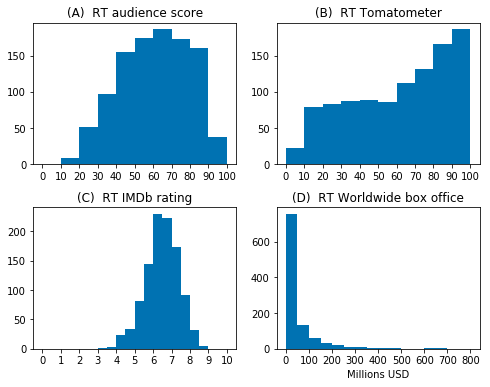

In [74]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

axes[0, 0].hist(df['audienceScore'], bins = 10, range = (0, 100))
axes[0, 1].hist(df['tomatoMeter'], bins = 10, range = (0, 100))
axes[1, 0].hist(df['averageRating'], bins = 20, range = (0, 10))
axes[1, 1].hist(df['boWorldwide'], bins = 16, range = (0, 800))

#axes[0, 0].set_xlabel('RT audience score')
#axes[0, 1].set_xlabel('RT Tomatometer')
#axes[1, 0].set_xlabel('IMDB rating')
axes[1, 1].set_xlabel('Millions USD')

axes[0, 0].set_xticks(np.arange(0, 110, step = 10))
axes[0, 1].set_xticks(np.arange(0, 110, step = 10))
axes[1, 0].set_xticks(np.arange(0, 11, step = 1))
axes[1, 1].set_xticks(np.arange(0, 900, step = 100))

axes[0, 0].set_title('(A)  RT audience score')
axes[0, 1].set_title('(B)  RT Tomatometer')
axes[1, 0].set_title('(C)  RT IMDb rating')
axes[1, 1].set_title('(D)  RT Worldwide box office')

plt.subplots_adjust(hspace = 0.3)

plt.savefig('histograms.pdf')

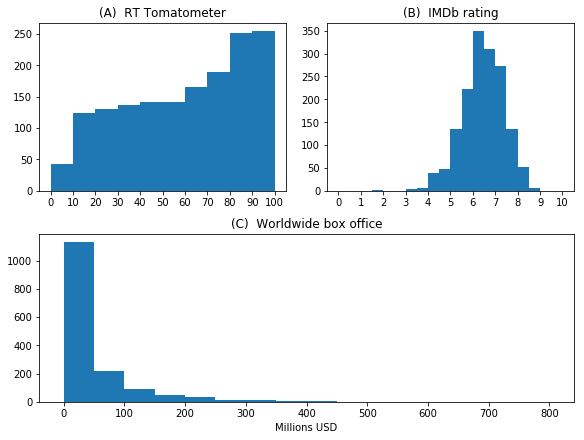

In [27]:
fig = plt.figure(constrained_layout = True, figsize = (8, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.hist(df['tomatoMeter'], bins = 10, range = (0, 100))
ax2.hist(df['averageRating'], bins = 20, range = (0, 10))
ax3.hist(df['boWorldwide'], bins = 16, range = (0, 800))

ax1.set_xticks(np.arange(0, 110, step = 10))
ax2.set_xticks(np.arange(0, 11, step = 1))
ax3.set_xticks(np.arange(0, 900, step = 100))

ax1.set_title('(A)  RT Tomatometer')
ax2.set_title('(B)  IMDb rating')
ax3.set_title('(C)  Worldwide box office')

ax3.set_xlabel('Millions USD')

plt.savefig('histograms.pdf', bbox_inches = 'tight')

### Plots

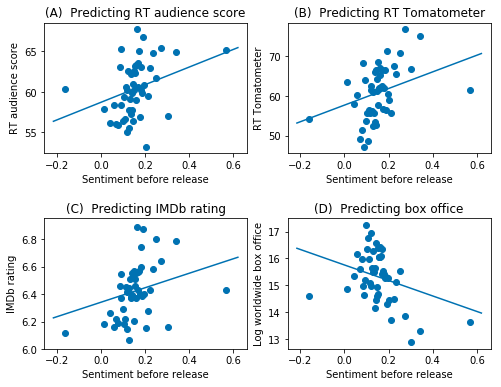

In [78]:
x_var = 'sentimentBefore'

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

df1 = df.dropna(subset = [x_var, 'averageRating'])
df2 = df.dropna(subset = [x_var, 'audienceScore'])
df3 = df.dropna(subset = [x_var, 'tomatoMeter'])
df4 = df.dropna(subset = [x_var, 'boWorldwide'])

axes[0, 0].binscatter(x = df1[x_var], y = df1['audienceScore'], n_bins = 50)
axes[0, 1].binscatter(x = df2[x_var], y = df2['tomatoMeter'], n_bins = 50)
axes[1, 0].binscatter(x = df3[x_var], y = df3['averageRating'], n_bins = 50)
axes[1, 1].binscatter(x = df4[x_var], y = df4['logBoWorldwide'], n_bins = 50)

axes[0, 0].set_xlabel('Sentiment before release')
axes[0, 1].set_xlabel('Sentiment before release')
axes[1, 0].set_xlabel('Sentiment before release')
axes[1, 1].set_xlabel('Sentiment before release')

axes[0, 0].set_ylabel('RT audience score')
axes[0, 1].set_ylabel('RT Tomatometer')
axes[1, 0].set_ylabel('IMDb rating')
axes[1, 1].set_ylabel('Log worldwide box office')

axes[0, 0].set_title('(A)  Predicting RT audience score')
axes[0, 1].set_title('(B)  Predicting RT Tomatometer')
axes[1, 0].set_title('(C)  Predicting IMDb rating')
axes[1, 1].set_title('(D)  Predicting box office')

plt.subplots_adjust(hspace = 0.5)

plt.savefig('binscatters.pdf')

In [ ]:
import statsmodels.api as sm # import statsmodels 

X = df[['sentimentBefore', 'pos_frac', 'numCommentsBefore']] ## X usually means our input variables (or independent variables)
y = df['averageRating'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()